In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import zscore
import os
import glob

In [5]:
data_dir = "stock_data"
stock_list = ['GME', 'AMC', 'TLRY', 'SNDL', 'ZOM', 'AAPL', 'TSLA', 'GOEV', 'PLUG']
all_data = []
for stock in stock_list:
    file_path = os.path.join(data_dir, f"{stock}_daily.csv")
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df['Ticker'] = stock
    all_data.append(df)

# Combine all into one DataFrame
df = pd.concat(all_data, ignore_index=True)
df.sort_values(by=["Ticker", "Date"], inplace=True)
df.reset_index(drop=True, inplace=True)

df

,Date,Open,High,Low,Close,Volume,Ticker
0,2018-01-02 00:00:00-05:00,39.986349,40.489233,39.774854,40.479832,102223600,AAPL
1,2018-01-03 00:00:00-05:00,40.543277,41.017963,40.409333,40.472778,118071600,AAPL
2,2018-01-04 00:00:00-05:00,40.545623,40.764168,40.437528,40.660770,89738400,AAPL
3,2018-01-05 00:00:00-05:00,40.757138,41.210672,40.665491,41.123726,94640000,AAPL
4,2018-01-08 00:00:00-05:00,40.970982,41.267071,40.872282,40.970982,82271200,AAPL
...,...,...,...,...,...,...,...
12291,2023-12-22 00:00:00-05:00,0.211000,0.220000,0.210000,0.217600,4682395,ZOM
12292,2023-12-26 00:00:00-05:00,0.216800,0.228500,0.214500,0.221900,9352873,ZOM
12293,2023-12-27 00:00:00-05:00,0.222500,0.228400,0.211000,0.215000,5095105,ZOM
12294,2023-12-28 00:00:00-05:00,0.216000,0.218200,0.207000,0.210000,4325280,ZOM


In [10]:
# Check basic info
print(df.info())

## Pump-and-dump or insider activity often causes extreme short-term movements.

# Compute daily return and 7-day rolling volatility
df['Return'] = df.groupby('Ticker')['Close'].pct_change() # Helps spot extreme changes, one of the major flags for manipulation.
df['Volatility'] = df.groupby('Ticker')['Return'].rolling(window=7).std().reset_index(0, drop=True) # Manipulated stocks often have large price fluctuations over short windows

## Z-score > 3 indicates behavior that is statistically abnormal and may suggest manipulative events
# Z-scores for Volume and Return
df['Volume_Zscore'] = df.groupby('Ticker')['Volume'].transform(lambda x: (x - x.mean()) / x.std())
df['Return_Zscore'] = df.groupby('Ticker')['Return'].transform(lambda x: (x - x.mean()) / x.std())

df['Manipulation_Flag'] = ((df['Volume_Zscore'] > 3) & (df['Return_Zscore'] > 3)).astype(int)

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12296 entries, 0 to 12295
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           12296 non-null  object 
 1   Open           12296 non-null  float64
 2   High           12296 non-null  float64
 3   Low            12296 non-null  float64
 4   Close          12296 non-null  float64
 5   Volume         12296 non-null  int64  
 6   Ticker         12296 non-null  object 
 7   Return         12287 non-null  float64
 8   Volatility     12233 non-null  float64
 9   Volume_Zscore  12296 non-null  float64
 10  Return_Zscore  12287 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 1.0+ MB
None


,Date,Open,High,Low,Close,Volume,Ticker,Return,Volatility,Volume_Zscore,Return_Zscore,Manipulation_Flag
0,2018-01-02 00:00:00-05:00,39.986349,40.489233,39.774854,40.479832,102223600,AAPL,NaN,NaN,-0.092570,NaN,0
1,2018-01-03 00:00:00-05:00,40.543277,41.017963,40.409333,40.472778,118071600,AAPL,-0.000174,NaN,0.194878,-0.070361,0
2,2018-01-04 00:00:00-05:00,40.545623,40.764168,40.437528,40.660770,89738400,AAPL,0.004645,NaN,-0.319025,0.171144,0
3,2018-01-05 00:00:00-05:00,40.757138,41.210672,40.665491,41.123726,94640000,AAPL,0.011386,NaN,-0.230121,0.508955,0
4,2018-01-08 00:00:00-05:00,40.970982,41.267071,40.872282,40.970982,82271200,AAPL,-0.003714,NaN,-0.454464,-0.247764,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12291,2023-12-22 00:00:00-05:00,0.211000,0.220000,0.210000,0.217600,4682395,ZOM,0.003690,0.076343,-0.300652,0.032187,0
12292,2023-12-26 00:00:00-05:00,0.216800,0.228500,0.214500,0.221900,9352873,ZOM,0.019761,0.072518,-0.210634,0.240736,0
12293,2023-12-27 00:00:00-05:00,0.222500,0.228400,0.211000,0.215000,5095105,ZOM,-0.031095,0.078142,-0.292697,-0.419208,0
12294,2023-12-28 00:00:00-05:00,0.216000,0.218200,0.207000,0.210000,4325280,ZOM,-0.023256,0.066950,-0.307534,-0.317481,0


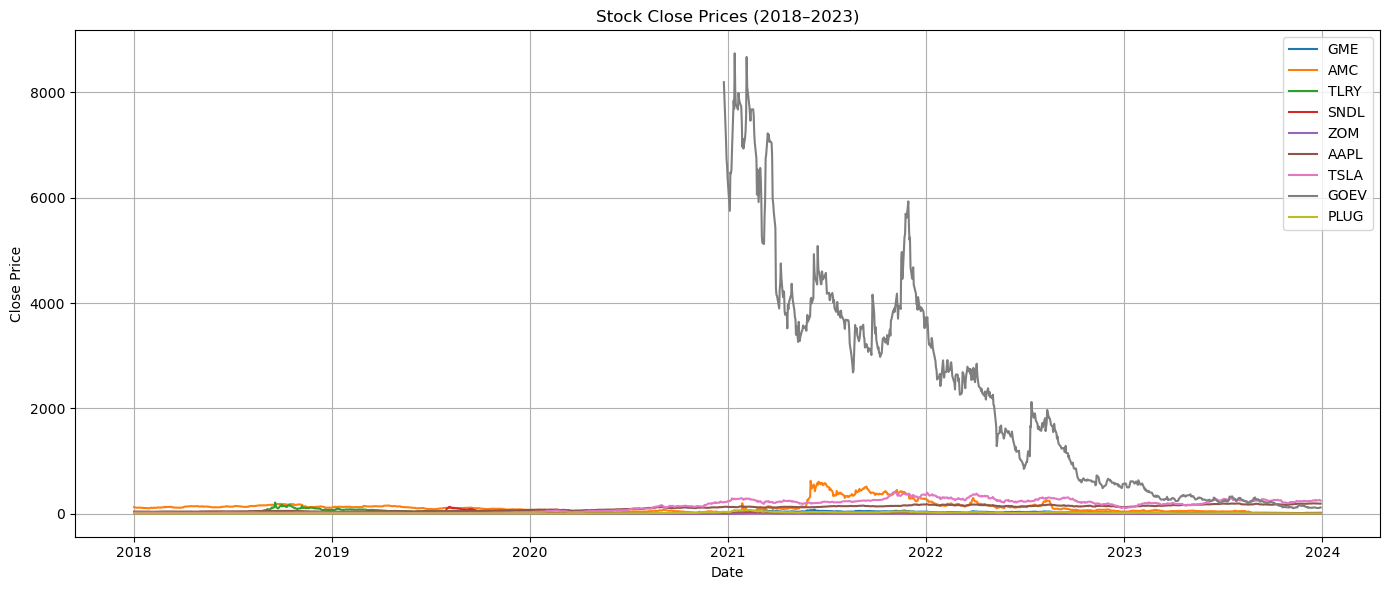

In [13]:
# Plot stock prices over time
plt.figure(figsize=(14, 6))
for ticker in stock_list:
    subset = df[df['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Close'], label=ticker)

plt.title('Stock Close Prices (2018–2023)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

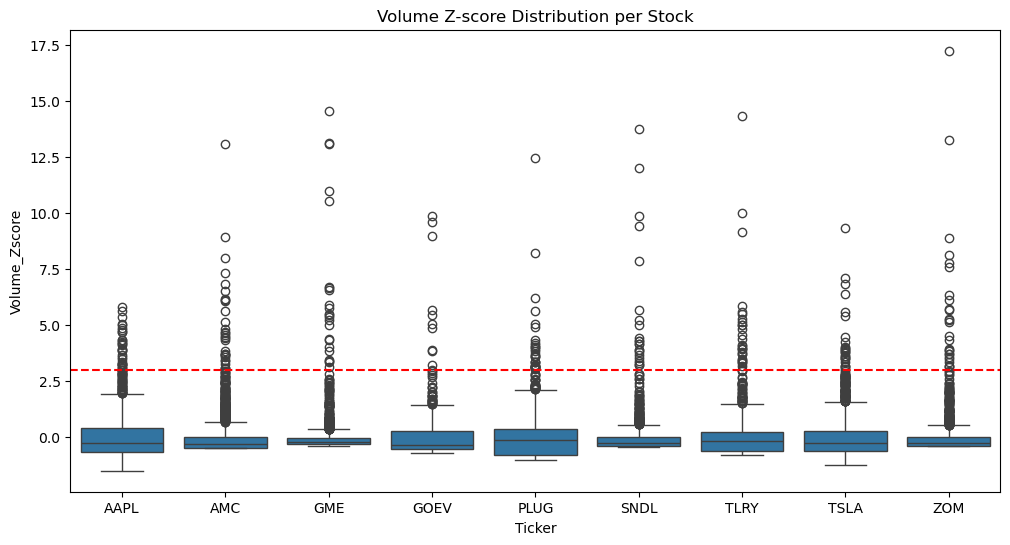

In [15]:
# Violin plots for volume anomalies
plt.figure(figsize=(12, 6))
sns.boxplot(x='Ticker', y='Volume_Zscore', data=df)
plt.title("Volume Z-score Distribution per Stock")
plt.axhline(3, linestyle='--', color='red')
plt.show()

In [19]:
# Show top suspicious events
suspicious_events = df[df['Manipulation_Flag'] == 1]
suspicious_events[['Date', 'Ticker', 'Return', 'Volume', 'Return_Zscore', 'Volume_Zscore']].sort_values(by=['Date', 'Ticker'])

,Date,Ticker,Return,Volume,Return_Zscore,Volume_Zscore
9734,2019-10-24 00:00:00-04:00,TSLA,0.176692,445813500,4.338131,3.736393
9802,2020-02-03 00:00:00-05:00,TSLA,0.198949,705975000,4.892193,6.846302
9803,2020-02-04 00:00:00-05:00,TSLA,0.137256,914082000,3.356388,9.333964
543,2020-03-02 00:00:00-05:00,AAPL,0.093101,341397200,4.603996,4.245526
549,2020-03-10 00:00:00-04:00,AAPL,0.072021,285290000,3.547623,3.227862
552,2020-03-13 00:00:00-04:00,AAPL,0.119808,370732000,5.942404,4.777596
9834,2020-03-19 00:00:00-04:00,TSLA,0.183877,452932500,4.516987,3.821492
559,2020-03-24 00:00:00-04:00,AAPL,0.100325,287531200,4.966040,3.268512
11377,2020-05-07 00:00:00-04:00,ZOM,0.354062,184427843,4.578859,3.163727
5908,2020-06-24 00:00:00-04:00,PLUG,0.177294,87133400,3.393611,4.213896


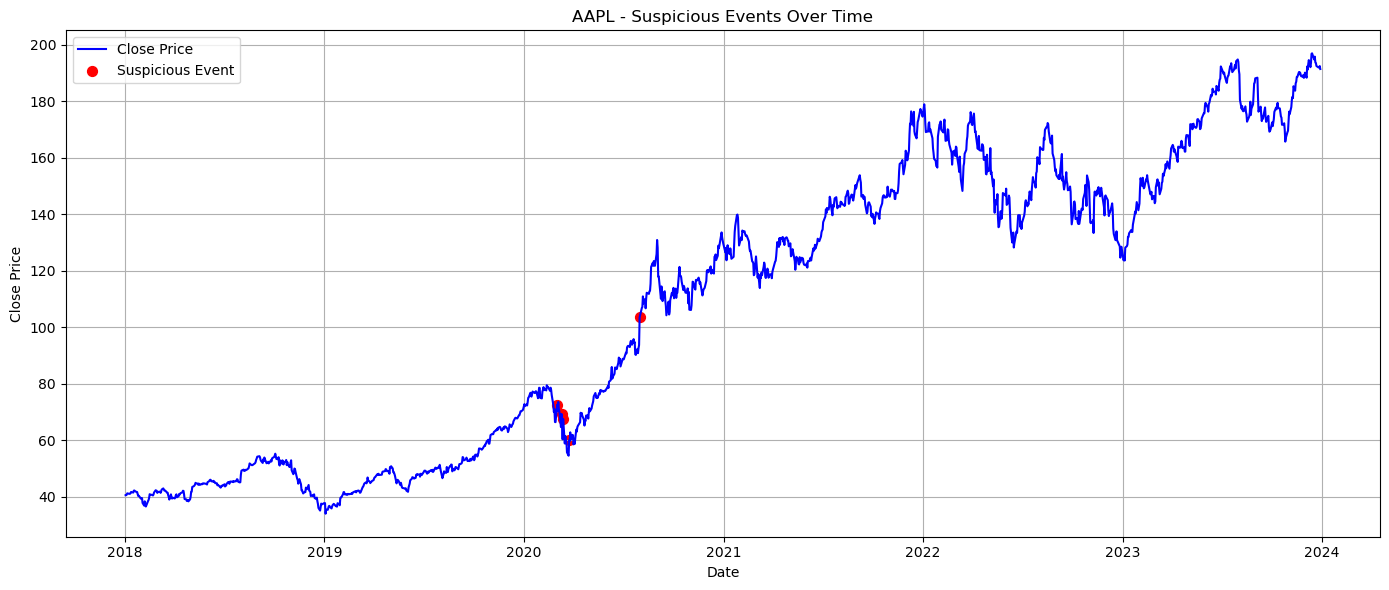

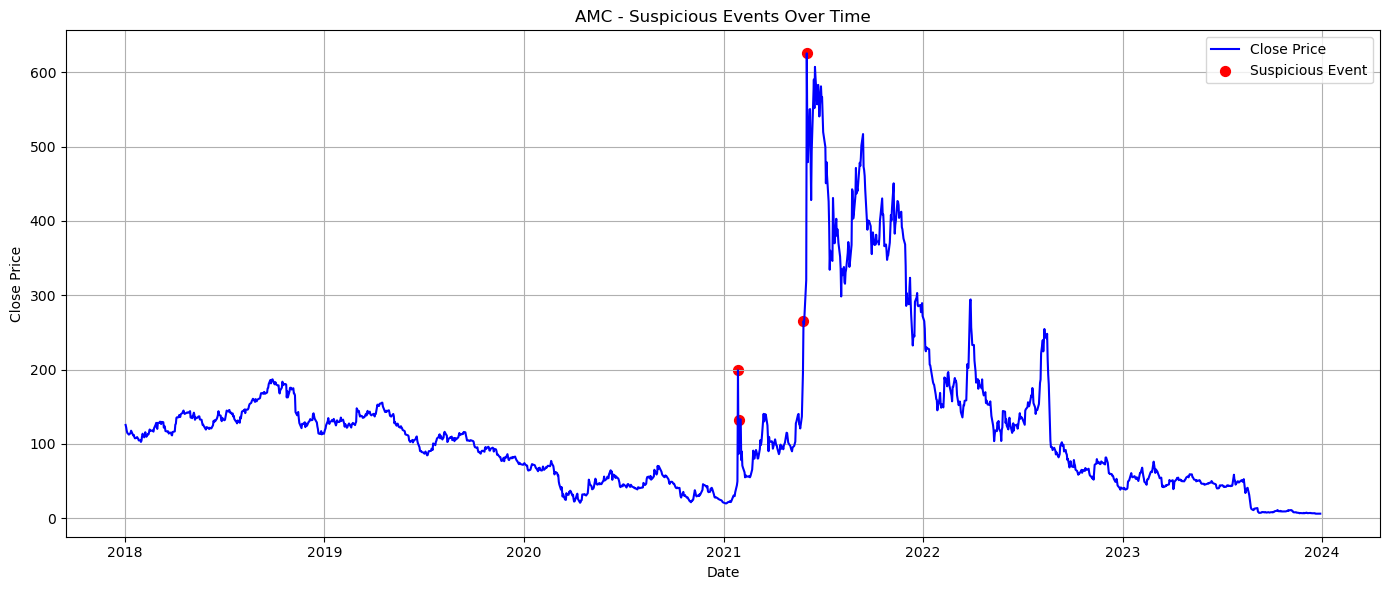

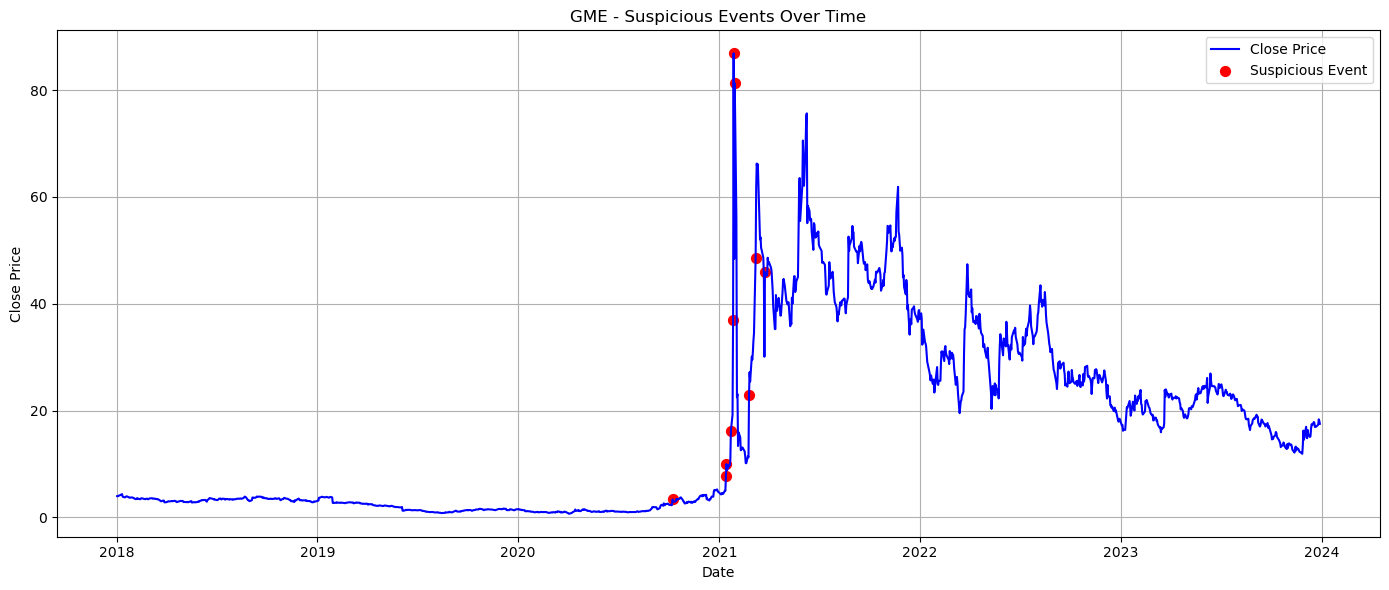

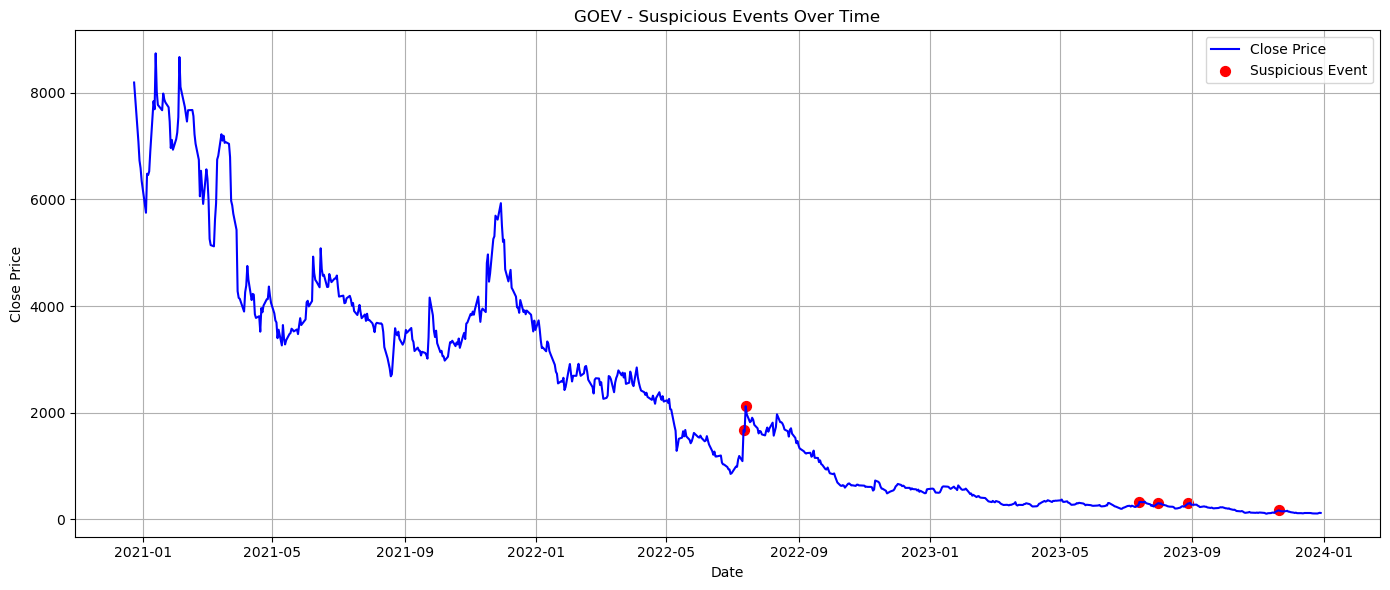

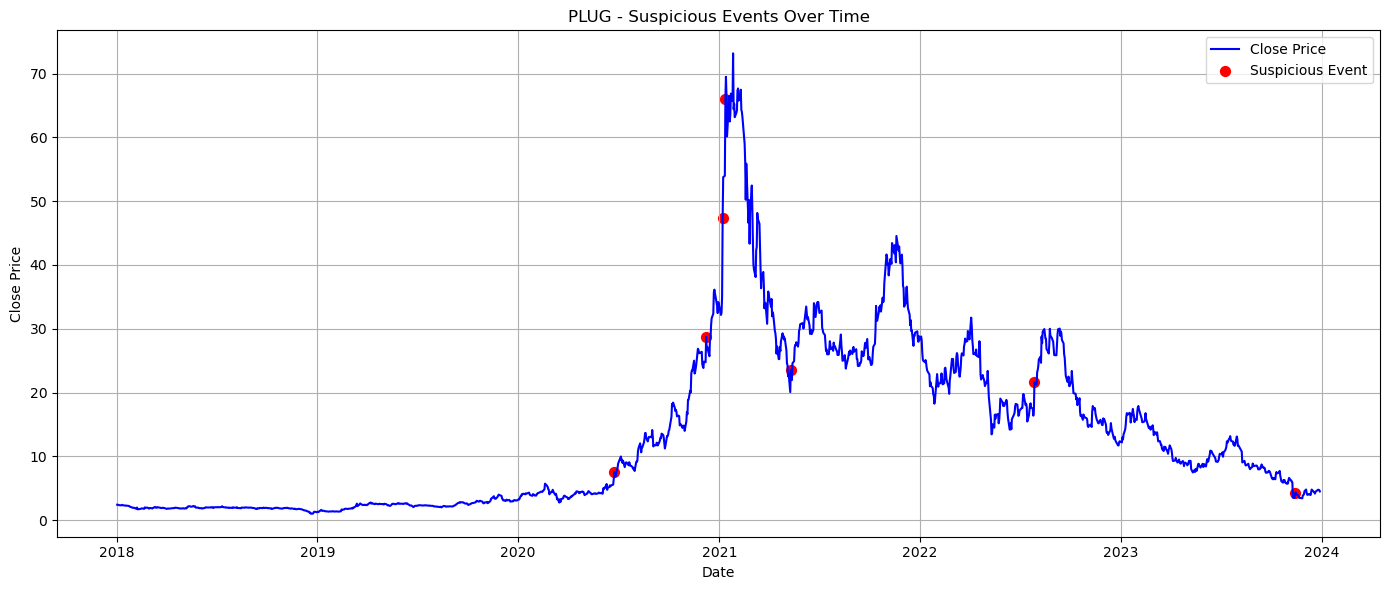

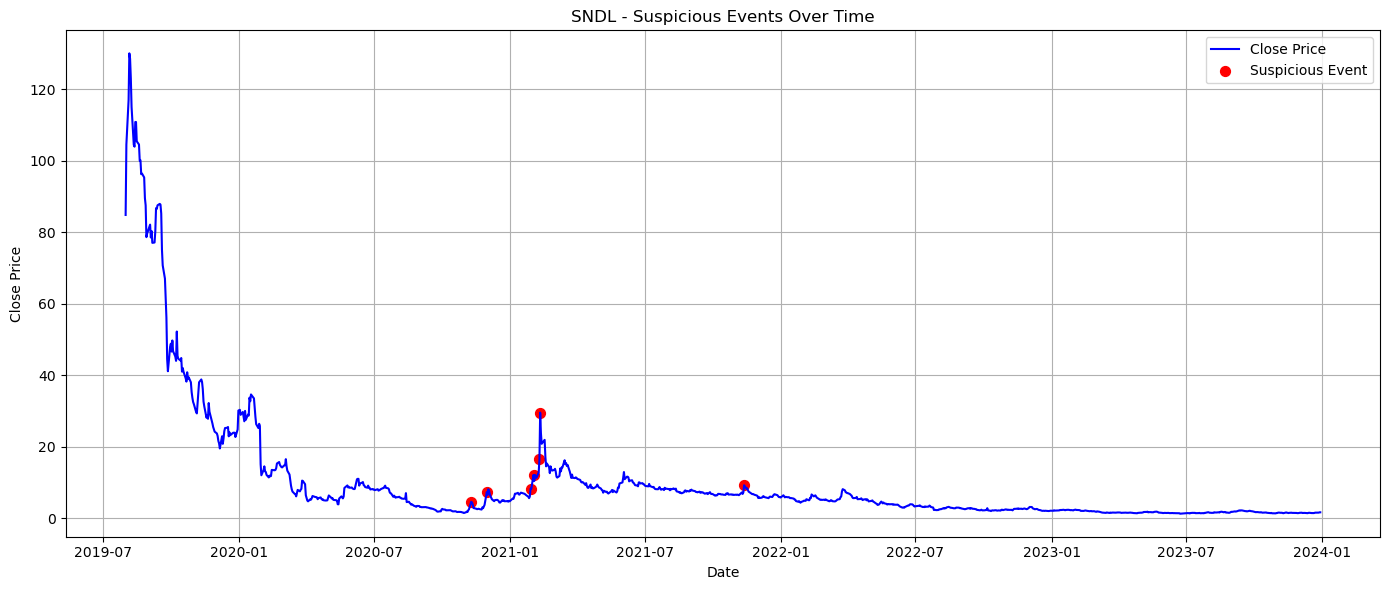

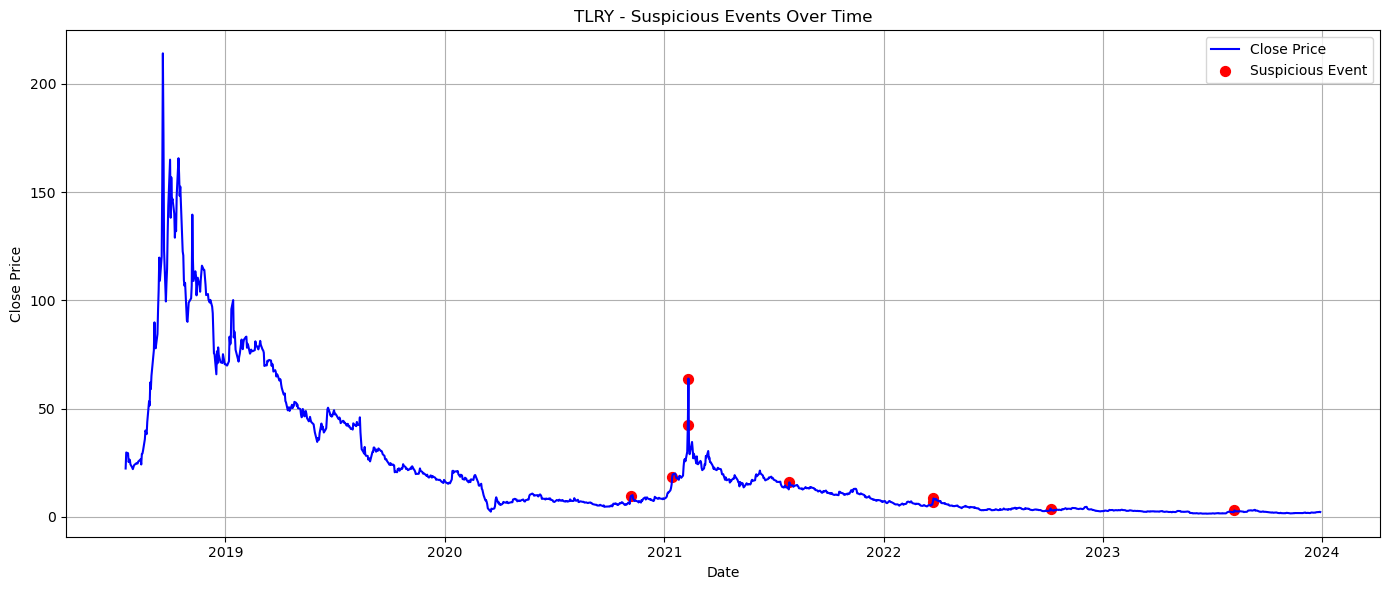

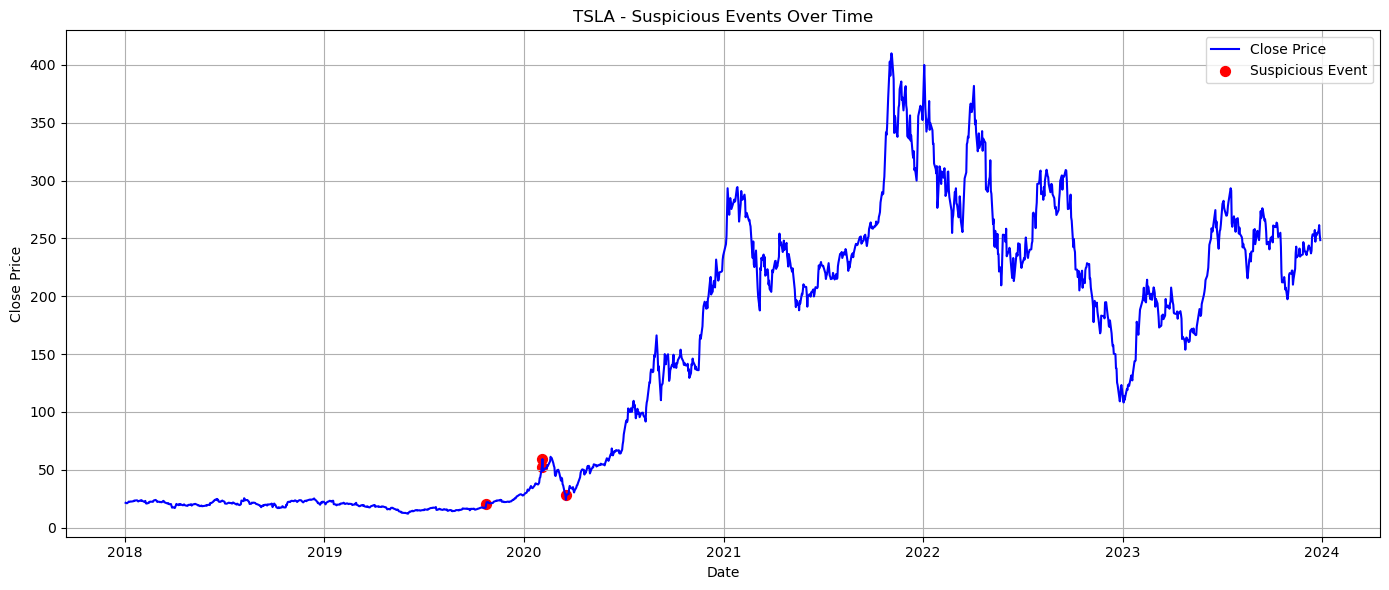

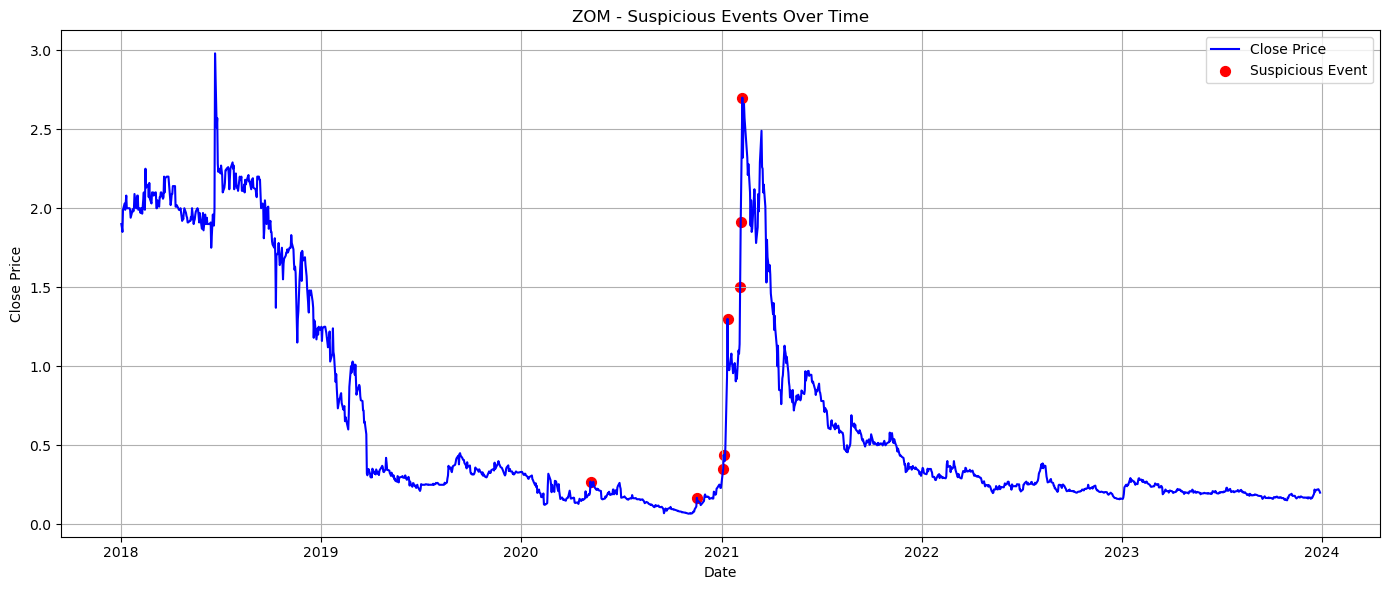

In [20]:
for ticker in df['Ticker'].unique():
    stock_data = df[df['Ticker'] == ticker]
    flagged_data = stock_data[stock_data['Manipulation_Flag'] == 1]

    plt.figure(figsize=(14, 6))
    plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price', color='blue')
    plt.scatter(flagged_data['Date'], flagged_data['Close'], color='red', label='Suspicious Event', marker='o', s=50)
    
    plt.title(f"{ticker} - Suspicious Events Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()